# Lecture 8. Neural Networks

**How to train your neurons**

Joaquin Vanschoren

In [1]:
# Note: You'll need to install tensorflow-addons. One of these should work
# !pip install tensorflow_addons
# !pip install tfa-nightly

# Note: AdaMax is not yet supported in tensorflow-metal

In [2]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots 
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.4
    plt.rcParams.update(print_config)

## Overview
* Neural architectures
* Training neural nets
    * Forward pass: Tensor operations
    * Backward pass: Backpropagation
* Neural network design:
    * Activation functions
    * Weight initialization
    * Optimizers
* Neural networks in practice
* Model selection
    * Early stopping
    * Memorization capacity and information bottleneck
    * L1/L2 regularization
    * Dropout
    * Batch normalization


In [3]:
def draw_neural_net(ax, layer_sizes, draw_bias=False, labels=False, activation=False, sigmoid=False,
                    weight_count=False, random_weights=False, show_activations=False, figsize=(4, 4)):
    """
    Draws a dense neural net for educational purposes
    Parameters:
        ax: plot axis
        layer_sizes: array with the sizes of every layer
        draw_bias: whether to draw bias nodes
        labels: whether to draw labels for the weights and nodes
        activation: whether to show the activation function inside the nodes
        sigmoid: whether the last activation function is a sigmoid
        weight_count: whether to show the number of weights and biases
        random_weights: whether to show random weights as colored lines
        show_activations: whether to show a variable for the node activations
        scale_ratio: ratio of the plot dimensions, e.g. 3/4
    """
    figsize = (figsize[0]*fig_scale, figsize[1]*fig_scale)
    left, right, bottom, top = 0.1, 0.89*figsize[0]/figsize[1], 0.1, 0.89
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    colors = ['greenyellow','cornflowerblue','lightcoral']
    w_count, b_count = 0, 0
    ax.set_xlim(0, figsize[0]/figsize[1])
    ax.axis('off')
    ax.set_aspect('equal')
    txtargs = {"fontsize":12*fig_scale, "verticalalignment":'center', "horizontalalignment":'center', "zorder":5}
    
    # Draw biases by adding a node to every layer except the last one
    if draw_bias:
        layer_sizes = [x+1 for x in layer_sizes]
        layer_sizes[-1] = layer_sizes[-1] - 1
        
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2. 
        node_size = v_spacing/len(layer_sizes) if activation and n!=0 else v_spacing/3.
        if n==0:
            color = colors[0]
        elif n==len(layer_sizes)-1:
            color = colors[2]
        else:
            color = colors[1]
        for m in range(layer_size):
            ax.add_artist(plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), radius=node_size,
                                      color=color, ec='k', zorder=4, linewidth=fig_scale))
            b_count += 1
            nx, ny = n*h_spacing + left, layer_top - m*v_spacing
            nsx, nsy = [n*h_spacing + left,n*h_spacing + left], [layer_top - m*v_spacing - 0.5*node_size*2,layer_top - m*v_spacing + 0.5*node_size*2]
            if draw_bias and m==0 and n<len(layer_sizes)-1:
                ax.text(nx, ny, r'$1$', **txtargs)
            elif labels and n==0:
                ax.text(n*h_spacing + left,layer_top + v_spacing/1.5, 'input', **txtargs)
                ax.text(nx, ny, r'$x_{}$'.format(m), **txtargs)
            elif labels and n==len(layer_sizes)-1:
                if activation:
                    if sigmoid:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z \;\;\; \sigma$", **txtargs)
                    else:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; g$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:        
                        ax.text(n*h_spacing + left + 1.5*node_size,layer_top - m*v_spacing, r"$\hat{y}$", fontsize=12*fig_scale, 
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='r')

                else:
                    ax.text(nx, ny, r'$o_{}$'.format(m), **txtargs)
                ax.text(n*h_spacing + left,layer_top + v_spacing, 'output', **txtargs)
            elif labels:
                if activation:
                    ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; f$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:        
                        ax.text(n*h_spacing + left + node_size*1.2 ,layer_top - m*v_spacing, r"$a_{}$".format(m), fontsize=12*fig_scale, 
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='b')
                else:
                    ax.text(nx, ny, r'$h_{}$'.format(m), **txtargs)
                
            
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                if not (draw_bias and o==0 and len(layer_sizes)>2 and n<layer_size_b-1):
                    xs = [n*h_spacing + left, (n + 1)*h_spacing + left]
                    ys = [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing]
                    color = 'k' if not random_weights else plt.cm.bwr(np.random.random())
                    ax.add_artist(plt.Line2D(xs, ys, c=color, alpha=0.6))
                    if not (draw_bias and m==0):
                        w_count += 1
                    if labels and not random_weights:
                        wl = r'$w_{{{},{}}}$'.format(m,o) if layer_size_b>1 else r'$w_{}$'.format(m)
                        ax.text(xs[0]+np.diff(xs)/2, np.mean(ys)-np.diff(ys)/9, wl, ha='center', va='center', 
                                 fontsize=12*fig_scale)
    # Count
    if weight_count:
        b_count = b_count - layer_sizes[0]
        if draw_bias:
            b_count = b_count - (len(layer_sizes) - 2)
        ax.text(right*1.05, bottom, "{} weights, {} biases".format(w_count, b_count), ha='center', va='center')


## Architecture
* Logistic regression, drawn in a different, neuro-inspired, way
    * Linear model: inner product ($z$) of input vector $\mathbf{x}$ and weight vector $\mathbf{w}$, plus bias $w_0$
    * Logistic (or sigmoid) function maps the output to a probability in [0,1]
    * Uses log loss (cross-entropy) and gradient descent to learn the weights
        
$$\hat{y}(\mathbf{x}) = \text{sigmoid}(z) = \text{sigmoid}(w_0 + \mathbf{w}\mathbf{x}) = \text{sigmoid}(w_0 + w_1 * x_1 + w_2 * x_2 +... + w_p * x_p)$$

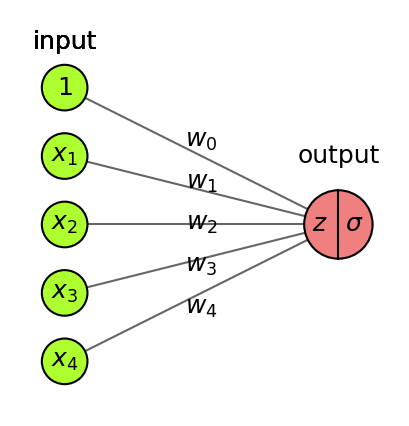

In [4]:
fig = plt.figure(figsize=(3*fig_scale,3*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [4, 1], activation=True, draw_bias=True, labels=True, sigmoid=True)

### Basic Architecture
* Add one (or more) _hidden_ layers $h$ with $k$ nodes (or units, cells, neurons)
    * Every 'neuron' is a tiny function, the network is an arbitrarily complex function
    * Weights $w_{i,j}$ between node $i$ and node $j$ form a weight matrix $\mathbf{W}^{(l)}$ per layer $l$
* Every neuron weights the inputs $\mathbf{x}$ and passes it through a non-linear activation function
    * Activation functions ($f,g$) can be different per layer, output $\mathbf{a}$ is called activation
$$\color{blue}{h(\mathbf{x})} = \color{blue}{\mathbf{a}} = f(\mathbf{z}) = f(\mathbf{W}^{(1)} \color{green}{\mathbf{x}}+\mathbf{w}^{(1)}_0) \quad \quad \color{red}{o(\mathbf{x})} = g(\mathbf{W}^{(2)}  \color{blue}{\mathbf{a}}+\mathbf{w}^{(2)}_0)$$

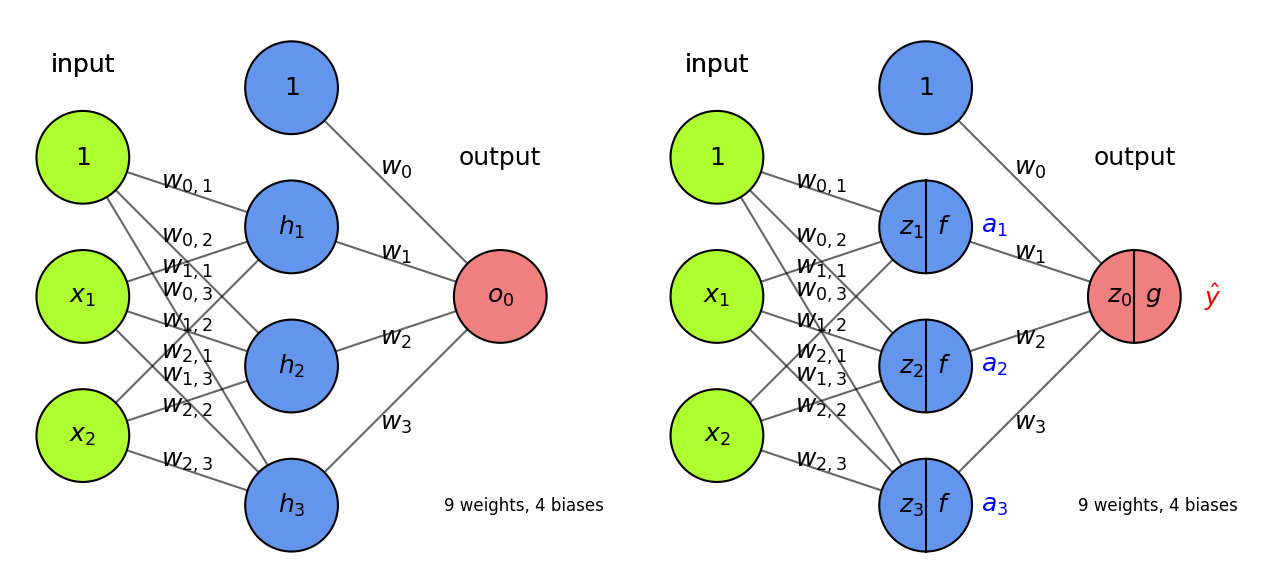

In [5]:
fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,5*fig_scale))
draw_neural_net(axes[0], [2, 3, 1],  draw_bias=True, labels=True, weight_count=True, figsize=(4, 4))
draw_neural_net(axes[1], [2, 3, 1],  activation=True, show_activations=True, draw_bias=True, 
                labels=True, weight_count=True,  figsize=(4, 4))

### More layers
* Add more layers, and more nodes per layer, to make the model more complex
    * For simplicity, we don't draw the biases (but remember that they are there)
* In _dense_ (fully-connected) layers, every previous layer node is connected to all nodes
* The output layer can also have multiple nodes (e.g. 1 per class in multi-class classification)

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_dense_net(nr_layers=(0,6,1), nr_nodes=(1,12,1)):
    fig = plt.figure(figsize=(10*fig_scale, 5*fig_scale))
    ax = fig.gca()
    ax.axis('off')
    hidden = [nr_nodes]*nr_layers
    draw_neural_net(ax, [5] + hidden + [5], weight_count=True, figsize=(6, 4));

interactive(children=(IntSlider(value=3, description='nr_layers', max=6), IntSlider(value=6, description='nr_n…

In [7]:
if not interactive:
    plot_dense_net(nr_layers=6, nr_nodes=10)

### Why layers?
* Each layer acts as a _filter_ and learns a new _representation_ of the data
    * Subsequent layers can learn iterative refinements
    * Easier that learning a complex relationship in one go
* Example: for image input, each layer yields new (filtered) images
    * Can learn multiple mappings at once: weight _tensor_ $\mathit{W}$ yields activation tensor $\mathit{A}$
    * From low-level patterns (edges, end-points, ...) to combinations thereof
    * Each neuron 'lights up' if certain patterns occur in the input

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/00_layers2.png" alt="ml" style="width: 50%"/>

### Other architectures
* There exist MANY types of networks for many different tasks
* Convolutional nets for image data, Recurrent nets for sequential data,...
* Also used to learn representations (embeddings), generate new images, text,...

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/neural_zoo.png" alt="ml" style="width: 1200px;"/>

## Training Neural Nets
* Design the architecture, choose activation functions (e.g. sigmoids)
* Choose a way to initialize the weights (e.g. random initialization)
* Choose a _loss function_ (e.g. log loss) to measure how well the model fits training data
* Choose an _optimizer_ (typically an SGD variant) to update the weights

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_overview.png" alt="ml" style="width: 45%"/>

### Mini-batch Stochastic Gradient Descent (recap)
1. Draw a batch of *batch_size* training data $\mathbf{X}$ and $\mathbf{y}$
2. _Forward pass_ : pass $\mathbf{X}$ though the network to yield predictions $\mathbf{\hat{y}}$
3. Compute the loss $\mathcal{L}$ (mismatch between  $\mathbf{\hat{y}}$ and $\mathbf{y}$)
4. _Backward pass_ : Compute the gradient of the loss with regard to every weight
    * _Backpropagate_ the gradients through all the layers
5. Update $W$: $W_{(i+1)} = W_{(i)} - \frac{\partial L(x, W_{(i)})}{\partial W} * \eta$

Repeat until n passes (epochs) are made through the entire training set

In [8]:
# TODO: show the actual weight updates
@interact
def draw_updates(iteration=(1,100,1)):
    fig, ax = plt.subplots(1, 1, figsize=(6*fig_scale, 4*fig_scale))
    np.random.seed(iteration)
    draw_neural_net(ax, [6,5,5,3], labels=True, random_weights=True, show_activations=True, figsize=(6, 4));

interactive(children=(IntSlider(value=50, description='iteration', min=1), Output()), _dom_classes=('widget-in…

In [9]:
if not interactive:
    draw_updates(iteration=1)

### Forward pass
* We can naturally represent the data as _tensors_
    * Numerical n-dimensional array (with n axes)
    * 2D tensor: matrix (samples, features)
    * 3D tensor: time series (samples, timesteps, features)
    * 4D tensor: color images (samples, height, width, channels)
    * 5D tensor: video (samples, frames, height, width, channels)  
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_timeseries.png" alt="ml" style="float: left; width: 30%;"/>
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_images.png" alt="ml" style="float: left; width: 30%;"/>

#### Tensor operations
* The operations that the network performs on the data can be reduced to a _series of tensor operations_
    * These are also much easier to run on GPUs
* A dense layer with sigmoid activation, input tensor $\mathbf{X}$, weight tensor $\mathbf{W}$, bias $\mathbf{b}$:

``` python
y = sigmoid(np.dot(X, W) + b)
```
* Tensor dot product for 2D inputs ($a$ samples, $b$ features, $c$ hidden nodes)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_dot.png" alt="ml" style="width: 40%"/>

#### Element-wise operations

* Activation functions and addition are element-wise operations:

``` python
def sigmoid(x):
  return 1/(1 + np.exp(-x)) 

def add(x, y):
  return x + y
```

* Note: if y has a lower dimension than x, it will be _broadcasted_: axes are added to match the dimensionality, and y is repeated along the new axes 

``` python
>>> np.array([[1,2],[3,4]]) + np.array([10,20])
array([[11, 22],
       [13, 24]])
```

### Backward pass (backpropagation)
* For last layer, compute gradient of the loss function $\mathcal{L}$ w.r.t all weights of layer $l$

$$\nabla \mathcal{L} = \frac{\partial \mathcal{L}}{\partial W^{(l)}} = 
                  \begin{bmatrix}
                    \frac{\partial \mathcal{L}}{\partial w_{0,0}} & \ldots & \frac{\partial \mathcal{L}}{\partial w_{0,l}} \\
                    \vdots & \ddots & \vdots \\
                    \frac{\partial \mathcal{L}}{\partial w_{k,0}}  & \ldots & \frac{\partial \mathcal{L}}{\partial w_{k,l}}
                  \end{bmatrix}$$
                  
* Sum up the gradients for all $\mathbf{x}_j$ in minibatch: $\sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W^{(l)}}$
* Update all weights in a layer at once (with learning rate $\eta$): $W_{(i+1)}^{(l)} = W_{(i)}^{(l)} - \eta \sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W_{(i)}^{(l)}}$ 
* Repeat for next layer, iterating backwards (most efficient, avoids redundant calculations)
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/01_gradient_descent.jpg" alt="ml" style="width: 40%"/>

#### Example
* Imagine feeding a single data point, output is $\hat{y} = g(z) = g(w_0 + w_1 * a_1 + w_2 * a_2 +... + w_p * a_p)$
* Decrease loss by updating weights:
    * Update the weights of last layer to maximize improvement: 
   $w_{i,(new)} = w_{i} - \frac{\partial \mathcal{L}}{\partial w_i} * \eta$
    * To compute gradient $\frac{\partial \mathcal{L}}{\partial w_i}$ we need the chain rule: $f(g(x)) = f'(g(x)) * g'(x)$
$$\frac{\partial \mathcal{L}}{\partial w_i} = \color{red}{\frac{\partial \mathcal{L}}{\partial g}} \color{blue}{\frac{\partial \mathcal{g}}{\partial z_0}} \color{green}{\frac{\partial \mathcal{z_0}}{\partial w_i}}$$
* E.g., with $\mathcal{L} = \frac{1}{2}(y-\hat{y})^2$ and sigmoid $\sigma$: $\frac{\partial \mathcal{L}}{\partial w_i} = \color{red}{(y - \hat{y})} * \color{blue}{\sigma'(z_0)} * \color{green}{a_i}$

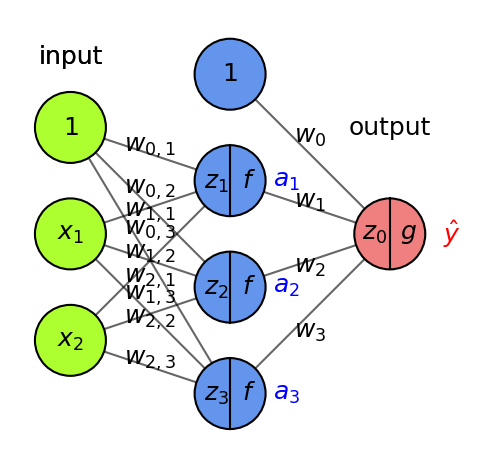

In [10]:
fig = plt.figure(figsize=(4*fig_scale, 3.5*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1],  activation=True, draw_bias=True, labels=True, 
                show_activations=True)

#### Backpropagation (2)
* Another way to decrease the loss $\mathcal{L}$ is to update the activations $a_i$
    * To update $a_i = f(z_i)$, we need to update the weights of the previous layer
    * We want to nudge $a_i$ in the right direction by updating $w_{i,j}$:
$$\frac{\partial \mathcal{L}}{\partial w_{i,j}} = \frac{\partial \mathcal{L}}{\partial a_i} \frac{\partial a_i}{\partial z_i} \frac{\partial \mathcal{z_i}}{\partial w_{i,j}} = \left( \frac{\partial \mathcal{L}}{\partial g} \frac{\partial \mathcal{g}}{\partial z_0} \frac{\partial \mathcal{z_0}}{\partial a_i} \right) \frac{\partial a_i}{\partial z_i} \frac{\partial \mathcal{z_i}}{\partial w_{i,j}}$$
    * We know $\frac{\partial \mathcal{L}}{\partial g}$ and $\frac{\partial \mathcal{g}}{\partial z_0}$ from the previous step, $\frac{\partial \mathcal{z_0}}{\partial a_i} = w_i$, $\frac{\partial a_i}{\partial z_i} = f'$ and $\frac{\partial \mathcal{z_i}}{\partial w_{i,j}} = x_j$

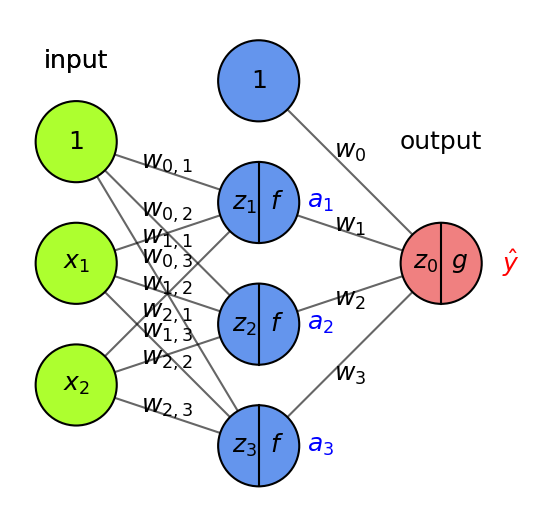

In [11]:
fig = plt.figure(figsize=(4*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1],  activation=True, draw_bias=True, labels=True, 
                show_activations=True)

#### Backpropagation (3)
* With multiple output nodes, $\mathcal{L}$ is the sum of all per-output (per-class) losses
    * $\frac{\partial \mathcal{L}}{\partial a_i}$ is sum of the gradients for every output
* Per layer, sum up gradients for every point $\mathbf{x}$ in the batch: $\sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W}$
* Update all weights of every layer $l$
    * $W_{(i+1)}^{(l)} = W_{(i)}^{(l)} - \eta \sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W_{(i)}^{(l)}}$ 
* Repeat with a new batch of data until loss converges
* [Nice animation of the entire process](https://youtu.be/Ilg3gGewQ5U?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&t=403)

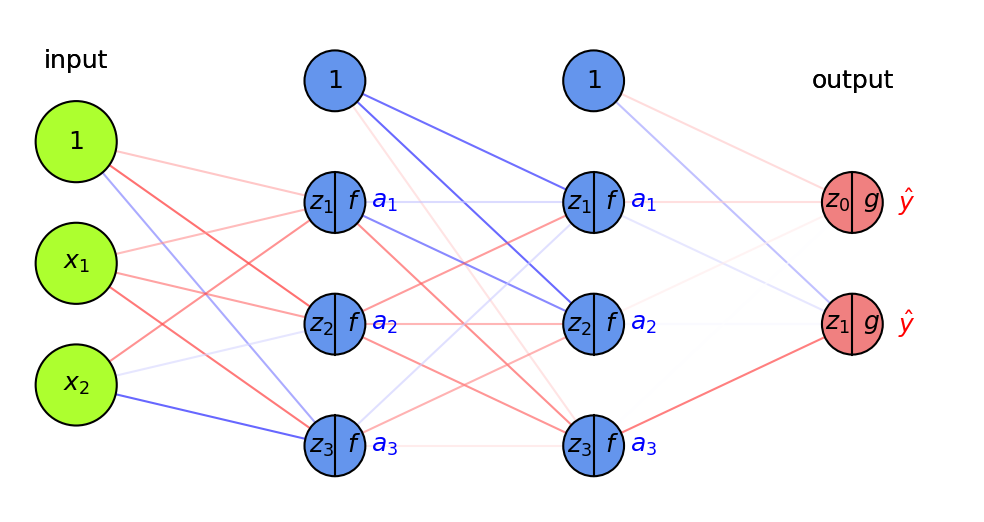

In [12]:
fig = plt.figure(figsize=(8*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 3, 2],  activation=True, draw_bias=True, labels=True, 
                random_weights=True, show_activations=True, figsize=(8, 4))

#### Summary
* The network output $a_o$ is defined by the weights $W^{(o)}$ and biases $\mathbf{b}^{(o)}$ of the output layer, and
* The activations of a hidden layer $h_1$ with activation function $a_{h_1}$, weights $W^{(1)}$ and biases $\mathbf{b^{(1)}}$:

$$\color{red}{a_o(\mathbf{x})} = \color{red}{a_o(\mathbf{z_0})} = \color{red}{a_o(W^{(o)}} \color{blue}{a_{h_1}(z_{h_1})} \color{red}{+ \mathbf{b}^{(o)})} = \color{red}{a_o(W^{(o)}} \color{blue}{a_{h_1}(W^{(1)} \color{green}{\mathbf{x}} + \mathbf{b}^{(1)})}
  \color{red}{+ \mathbf{b}^{(o)})} $$
  
* Minimize the loss by SGD. For layer $l$, compute $\frac{\partial \mathcal{L}(a_o(x))}{\partial W_l}$ and $\frac{\partial \mathcal{L}(a_o(x))}{\partial b_{l,i}}$ using the chain rule
* Decomposes into <span style="color:red">gradient of layer above</span>, <span style="color:blue">gradient of activation function</span>, <span style="color:green">gradient of layer input</span>:

$$\frac{\partial \mathcal{L}(a_o)}{\partial W^{(1)}} = \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_{h_1}}} \color{blue}{\frac{\partial a_{h_1}}{\partial z_{h_1}}} \color{green}{\frac{\partial z_{h_1}}{\partial W^{(1)}}} 
= \left( \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_o}} \color{blue}{\frac{\partial a_o}{\partial z_o}} \color{green}{\frac{\partial z_o}{\partial a_{h_1}}}\right) \color{blue}{\frac{\partial a_{h_1}}{\partial z_{h_1}}} \color{green}{\frac{\partial z_{h_1}}{\partial W^{(1)}}}  $$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/backprop_schema2.png" alt="ml" style="width: 800px;"/>

## Activation functions for hidden layers
* Sigmoid: $f(z) = \frac{1}{1+e^{-z}}$
* Tanh: $f(z) = \frac{2}{1+e^{-2z}} - 1$ 
    * Activations around 0 are better for gradient descent convergence
* Rectified Linear (ReLU): $f(z) = max(0,z)$ 
    * Less smooth, but much faster (note: not differentiable at 0)
* Leaky ReLU: $f(z) = \begin{cases} 0.01z & z<0 \\ z & otherwise \end{cases}$ 

In [13]:
def activation(X, function="sigmoid"):     
    if function == "sigmoid":      
        return 1.0/(1.0 + np.exp(-X))    
    if function == "softmax": 
        return np.exp(X) / np.sum(np.exp(X), axis=0)   
    elif function == "tanh":      
        return np.tanh(X)    
    elif function == "relu":      
        return np.maximum(0,X)    
    elif function == "leaky_relu":      
        return np.maximum(0.1*X,X)
    elif function == "none":      
        return X
    
def activation_derivative(X, function="sigmoid"):   
    if function == "sigmoid": 
        sig = 1.0/(1.0 + np.exp(-X))   
        return sig * (1 - sig)
    elif function == "tanh":      
        return 1 - np.tanh(X)**2   
    elif function == "relu":      
        return np.where(X > 0, 1, 0)
    elif function == "leaky_relu":    
        # Using 0.1 instead of 0.01 to make it visible in the plot
        return np.where(X > 0, 1, 0.1)
    elif function == "none":      
        return X/X
    
def plot_activation(function, ax, derivative=False):
    if function=="softmax":       
        x = np.linspace(-6,6,9)
        ax.plot(x,activation(x, function),lw=2, c='b', linestyle='-', marker='o')
    else:     
        x = np.linspace(-6,6,101)
        ax.plot(x,activation(x, function),lw=2, c='b', linestyle='-') 
        if derivative:
            if function == "relu" or function == "leaky_relu":
                ax.step(x,activation_derivative(x, function),lw=2, c='r', linestyle='-')
            else:
                ax.plot(x,activation_derivative(x, function),lw=2, c='r', linestyle='-')
    ax.set_xlabel("input", fontsize=16*fig_scale)
    ax.set_ylabel(function, fontsize=18*fig_scale)
    ax.tick_params(axis='both', labelsize=16*fig_scale)
    ax.grid()
    
functions = ["sigmoid","tanh","relu","leaky_relu"]

@interact
def plot_activations(function=functions):
    fig, ax = plt.subplots(figsize=(5,1.5))
    plot_activation(function, ax)

interactive(children=(Dropdown(description='function', options=('sigmoid', 'tanh', 'relu', 'leaky_relu'), valu…

In [14]:
if not interactive:
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    for function, ax in zip(functions,axes):
        plot_activation(function, ax)
    plt.tight_layout();

#### Effect of activation functions on the gradient
* During gradient descent, the gradient depends on the activation function $a_{h}$: $\frac{\partial \mathcal{L}(a_o)}{\partial W^{(l)}} = \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_{h_l}}} \color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}} \color{green}{\frac{\partial z_{h_l}}{\partial W^{(l)}}}$
* If derivative of the activation function $\color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}}$ is 0, the weights $w_i$ are not updated
    * Moreover, the gradients of previous layers will be reduced (vanishing gradient)
* sigmoid, tanh: gradient is very small for large inputs: slow updates
* With ReLU, $\color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}} = 1$ if $z>0$, hence better against vanishing gradients
    * Problem: for very negative inputs, the gradient is 0 and may never recover (dying ReLU)
    * Leaky ReLU has a small (0.01) gradient there to allow recovery

In [15]:
@interact
def plot_activations_derivative(function=functions):
    fig, ax = plt.subplots(figsize=(6,2))
    plot_activation(function, ax, derivative=True)
    plt.legend(['original','derivative'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.25), ncol=2)

interactive(children=(Dropdown(description='function', options=('sigmoid', 'tanh', 'relu', 'leaky_relu'), valu…

In [16]:
if not interactive:
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    for function, ax in zip(functions,axes):
        plot_activation(function, ax, derivative=True)
    fig.legend(['original','derivative'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.25), ncol=2)
    plt.tight_layout();

#### ReLU vs Tanh
* What is the effect of using non-smooth activation functions?
    * ReLU produces piecewise-linear boundaries, but allows deeper networks
    * Tanh produces smoother decision boundaries, but is slower

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from mglearn.plot_2d_separator import plot_2d_classification
import time

@interact
def plot_boundary(nr_layers=(1,4,1)):
    X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        random_state=42)
    
    # Multi-Layer Perceptron with ReLU
    mlp = MLPClassifier(solver='lbfgs', random_state=0,
                        hidden_layer_sizes=[10]*nr_layers)
    start = time.time()
    mlp.fit(X_train, y_train)
    relu_time = time.time() - start
    relu_acc = mlp.score(X_test, y_test)

    # Multi-Layer Perceptron with tanh
    mlp_tanh = MLPClassifier(solver='lbfgs', activation='tanh',
                             random_state=0, hidden_layer_sizes=[10]*nr_layers)
    start = time.time()
    mlp_tanh.fit(X_train, y_train)
    tanh_time = time.time() - start
    tanh_acc = mlp_tanh.score(X_test, y_test)

    fig, axes = plt.subplots(1, 2, figsize=(8*fig_scale, 4*fig_scale))
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[0].set_title("ReLU, acc: {:.2f}, time: {:.2f} sec".format(relu_acc, relu_time))
    plot_2d_classification(mlp, X_train, fill=True, cm='bwr', alpha=.3, ax=axes[0])
    axes[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[1].set_title("tanh, acc: {:.2f}, time: {:.2f} sec".format(tanh_acc, tanh_time))
    plot_2d_classification(mlp_tanh, X_train, fill=True, cm='bwr', alpha=.3, ax=axes[1])

interactive(children=(IntSlider(value=2, description='nr_layers', max=4, min=1), Output()), _dom_classes=('wid…

In [18]:
if not interactive:
    plot_boundary(nr_layers=2)

#### Activation functions for output layer
* _sigmoid_ converts output to probability in [0,1]
    * For binary classification 
* _softmax_ converts all outputs (aka 'logits') to probabilities that sum up to 1
    * For multi-class classification ($k$ classes)
    * Can cause over-confident models. If so, smooth the labels: $y_{smooth} = (1-\alpha)y + \frac{\alpha}{k}$
$$\text{softmax}(\mathbf{x},i) = \frac{e^{x_i}}{\sum_{j=1}^k e^{x_j}}$$
* For regression, don't use any activation function, let the model learn the exact target

In [19]:
output_functions = ["sigmoid","softmax","none"]

@interact
def plot_output_activation(function=output_functions):
    fig, ax = plt.subplots(figsize=(6,2))
    plot_activation(function, ax)

interactive(children=(Dropdown(description='function', options=('sigmoid', 'softmax', 'none'), value='sigmoid'…

In [20]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(8,2))
    for function, ax in zip(output_functions[:2],axes):
        plot_activation(function, ax)
    plt.tight_layout();

## Weight initialization
* Initializing weights to 0 is bad: all gradients in layer will be identical (symmetry)
* Too small random weights shrink activations to 0 along the layers (vanishing gradient)
* Too large random weights multiply along layers (exploding gradient, zig-zagging)
* Ideal: small random weights + variance of input and output gradients remains the same
  * Glorot/Xavier initialization (for tanh): randomly sample from  $N(0,\sigma), \sigma = \sqrt{\frac{2}{\text{fan_in + fan_out}}}$
    * fan_in: number of input units, fan_out: number of output units
  * He initialization (for ReLU): randomly sample from  $N(0,\sigma), \sigma = \sqrt{\frac{2}{\text{fan_in}}}$
  * Uniform sampling (instead of $N(0,\sigma)$) for deeper networks (w.r.t. vanishing gradients)



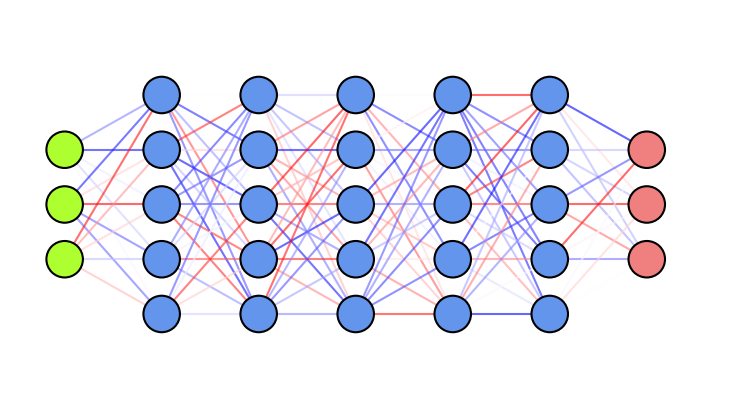

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6*fig_scale, 3*fig_scale))
draw_neural_net(ax, [3, 5, 5, 5, 5, 5, 3], random_weights=True, figsize=(6, 3))

### Weight initialization: transfer learning
* Instead of starting from scratch, start from weights previously learned from similar tasks
    * This is, to a big extent, how humans learn so fast
* Transfer learning: learn weights on task T, transfer them to new network
    * Weights can be frozen, or finetuned to the new data
* Only works if the previous task is 'similar' enough
    * Generally, weights learned on very diverse data (e.g. ImageNet) transfer better
    * Meta-learning: learn a good initialization across many related tasks

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/transfer_learning.png" alt="ml" style="width: 1000px;"/>

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa

# Toy surface
def f(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# Tensorflow optimizers
sgd = tf.optimizers.SGD(0.01)
lr_schedule = tf.optimizers.schedules.ExponentialDecay(0.02,decay_steps=100,decay_rate=0.96)
sgd_decay = tf.optimizers.SGD(learning_rate=lr_schedule)
#sgd_cyclic = tfa.optimizers.CyclicalLearningRate(initial_learning_rate= 0.1, maximal_learning_rate= 0.5, step_size=0.05)
clr_schedule = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4, maximal_learning_rate= 0.1, 
                                                   step_size=100, scale_fn=lambda x : x)
sgd_cyclic = tf.optimizers.SGD(learning_rate=clr_schedule)
momentum = tf.optimizers.SGD(0.005, momentum=0.9, nesterov=False)
nesterov = tf.optimizers.SGD(0.005, momentum=0.9, nesterov=True)
adagrad = tf.optimizers.Adagrad(0.4)
#adamax = tf.optimizers.Adamax(learning_rate=0.5, beta_1=0.9, beta_2=0.999) # AdaMax is still not supported in tensorflow-metal
#adadelta = tf.optimizers.Adadelta(learning_rate=1.0)
rmsprop = tf.optimizers.RMSprop(learning_rate=0.1)
#rmsprop_momentum = tf.optimizers.RMSprop(learning_rate=0.1, momentum=0.9)
adam = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

optimizers = [sgd, sgd_decay, momentum, nesterov, adagrad, rmsprop, adam, sgd_cyclic] #, adamax]
opt_names = ['sgd', 'sgd_decay', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'sgd_cyclic'] #,'adamax']
cmap = plt.cm.get_cmap('tab10')
colors = [cmap(x/10) for x in range(10)]

# Training
all_paths = []
for opt, name in zip(optimizers, opt_names):
    x = tf.Variable(0.8)
    y = tf.Variable(1.6)

    x_history = []
    y_history = []
    loss_prev = 0.0
    max_steps = 100
    for step in range(max_steps):
        with tf.GradientTape() as g:
            loss = f(x, y)
            x_history.append(x.numpy())
            y_history.append(y.numpy())
            grads = g.gradient(loss, [x, y])
            opt.apply_gradients(zip(grads, [x, y]))

    if np.abs(loss_prev - loss.numpy()) < 1e-6:
        break
    loss_prev = loss.numpy()
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
    all_paths.append(path)

Metal device set to: Apple M1 Pro


2023-09-22 09:09:17.551679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-22 09:09:17.551955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
x_min = 0. - 2
x_max = 0. + 3.5
y_min = 0. - 3.5
y_max = 0. + 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

def plot_optimizers(ax, iterations, optimizers):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    for name, path, color in zip(opt_names, all_paths, colors):
        if name in optimizers:
            p = path[:,:iterations]
            ax.plot([], [], color=color, label=name, lw=3*fig_scale, linestyle='-')
            ax.quiver(p[0,:-1], p[1,:-1], p[0,1:]-p[0,:-1], p[1,1:]-p[1,:-1], scale_units='xy', angles='xy', scale=1, color=color, lw=4)


    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 15*fig_scale}) 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

In [24]:
from decimal import *
from matplotlib.colors import LogNorm

# Training for momentum
all_lr_paths = []
lr_range = [0.005 * i for i in range(0,10)]
for lr in lr_range:
    opt = tf.optimizers.SGD(lr, nesterov=False)

    x_init = 0.8
    x = tf.compat.v1.get_variable('x', dtype=tf.float32, initializer=tf.constant(x_init))
    y_init = 1.6
    y = tf.compat.v1.get_variable('y', dtype=tf.float32, initializer=tf.constant(y_init))

    x_history = []
    y_history = []
    z_prev = 0.0
    max_steps = 100
    for step in range(max_steps):
        with tf.GradientTape() as g:
            z = f(x, y)
            x_history.append(x.numpy())
            y_history.append(y.numpy())
            dz_dx, dz_dy = g.gradient(z, [x, y])
            opt.apply_gradients(zip([dz_dx, dz_dy], [x, y]))

    if np.abs(z_prev - z.numpy()) < 1e-6:
        break
    z_prev = z.numpy()
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
    all_lr_paths.append(path)
    
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
x_min = 0. - 2
x_max = 0. + 3.5
y_min = 0. - 3.5
y_max = 0. + 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

def plot_learning_rate_optimizers(ax, iterations, lr):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    for path, lrate in zip(all_lr_paths, lr_range):
        if round(lrate,3) == lr:
            p = path[:,:iterations]
            ax.plot([], [], color='b', label="Learning rate {}".format(lr), lw=3*fig_scale, linestyle='-')
            ax.quiver(p[0,:-1], p[1,:-1], p[0,1:]-p[0,:-1], p[1,1:]-p[1,:-1], scale_units='xy', angles='xy', scale=1, color='b', lw=4)


    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 15*fig_scale}) 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

In [25]:
# Toy plot to illustrate nesterov momentum
# TODO: replace with actual gradient computation?
def plot_nesterov(ax, method="Nesterov momentum"):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    
    # toy example
    ax.quiver(-0.8,-1.13,1,1.33, scale_units='xy', angles='xy', scale=1, color='k', alpha=0.5, lw=3, label="previous update")
    # 0.9 * previous update
    ax.quiver(0.2,0.2,0.9,1.2, scale_units='xy', angles='xy', scale=1, color='g', lw=3, label="momentum step")
    if method == "Momentum":
        ax.quiver(0.2,0.2,0.5,0, scale_units='xy', angles='xy', scale=1, color='r', lw=3, label="gradient step")
        ax.quiver(0.2,0.2,0.9*0.9+0.5,1.2, scale_units='xy', angles='xy', scale=1, color='b', lw=3, label="actual step")
    if method == "Nesterov momentum":
        ax.quiver(1.1,1.4,-0.2,-1, scale_units='xy', angles='xy', scale=1, color='r', lw=3, label="'lookahead' gradient step")
        ax.quiver(0.2,0.2,0.7,0.2, scale_units='xy', angles='xy', scale=1, color='b', lw=3, label="actual step")

    ax.set_title(method)
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((-2.5, y_max))
    ax.legend(loc='lower right', prop={'size': 9*fig_scale})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

## Optimizers
### SGD with learning rate schedules
* Using a constant learning $\eta$ rate for weight updates $\mathbf{w}_{(s+1)} = \mathbf{w}_s-\eta\nabla \mathcal{L}(\mathbf{w}_s)$ is not ideal
    * You would need to 'magically' know the right value

In [26]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_lr(iterations=(1,100,1), learning_rate=(0.005,0.04,0.005)):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_learning_rate_optimizers(ax,iterations,round(learning_rate,3))
    
if not interactive:
    plot_lr(iterations=50, learning_rate=0.02)

interactive(children=(IntSlider(value=50, description='iterations', min=1), FloatSlider(value=0.02, descriptio…

### SGD with learning rate schedules
* Learning rate decay/annealing with decay rate $k$
    * E.g. exponential ($\eta_{s+1} = \eta_{0}  e^{-ks}$), inverse-time ($\eta_{s+1} = \frac{\eta_{0}}{1+ks}$),...
* Cyclical learning rates
    * Change from small to large: hopefully in 'good' region long enough before diverging
    * Warm restarts: aggressive decay + reset to initial learning rate

In [27]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

In [28]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,4*fig_scale))
    optimizers = ['sgd_decay', 'sgd_cyclic']
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

### Momentum
* Imagine a ball rolling downhill: accumulates momentum, doesn't exactly follow steepest descent
    * Reduces oscillation, follows larger (consistent) gradient of the loss surface
* Adds a velocity vector $\mathbf{v}$ with momentum $\gamma$ (e.g. 0.9, or increase from $\gamma=0.5$ to $\gamma=0.99$)
$$\mathbf{w}_{(s+1)} = \mathbf{w}_{(s)} + \mathbf{v}_{(s)} \qquad \text{with} \qquad
\color{blue}{\mathbf{v}_{(s)}} = \color{green}{\gamma \mathbf{v}_{(s-1)}} - \color{red}{\eta \nabla \mathcal{L}(\mathbf{w}_{(s)})}$$
* Nesterov momentum: Look where momentum step would bring you, compute gradient there 
    * Responds faster (and reduces momentum) when the gradient changes
$$\color{blue}{\mathbf{v}_{(s)}} = \color{green}{\gamma \mathbf{v}_{(s-1)}} - \color{red}{\eta \nabla \mathcal{L}(\mathbf{w}_{(s)} + \gamma \mathbf{v}_{(s-1)})}$$


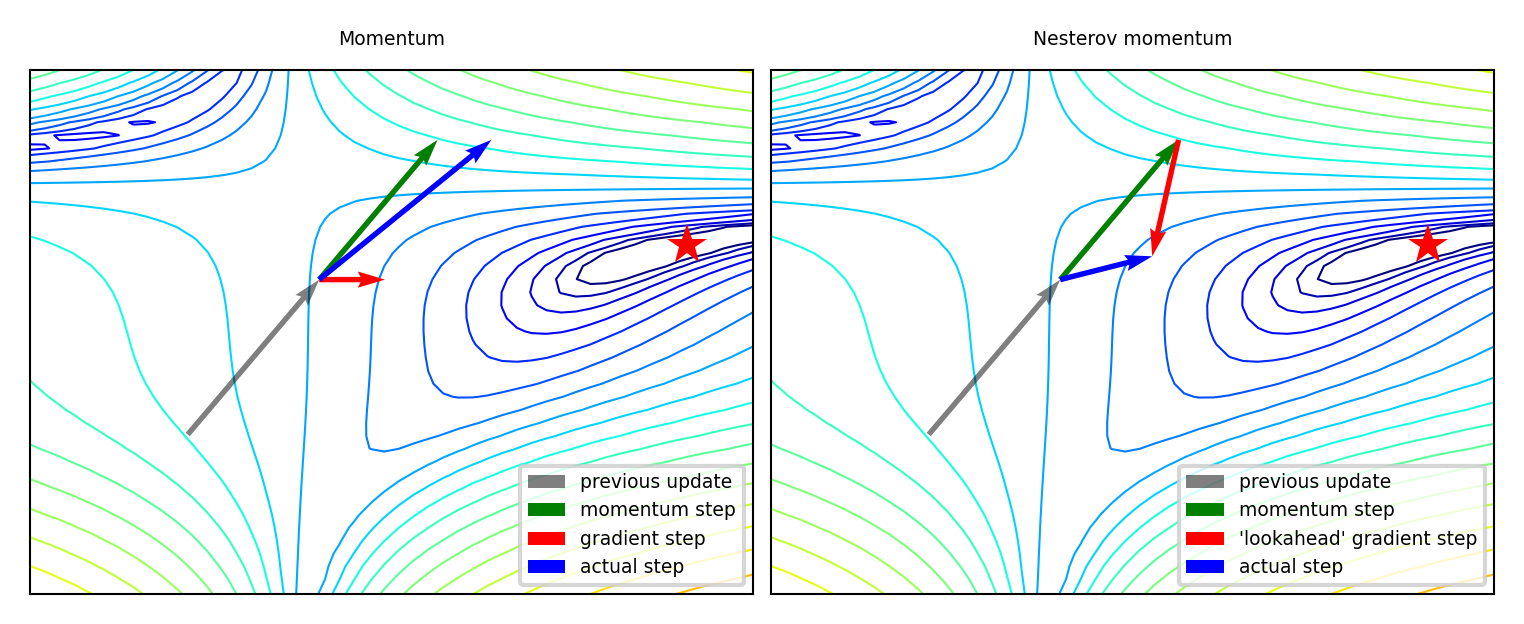

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,4*fig_scale))
plot_nesterov(axes[0],method="Momentum")
plot_nesterov(axes[1],method="Nesterov momentum")

#### Momentum in practice

In [30]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

In [31]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,3.5*fig_scale))
    optimizers = [['sgd','momentum'], ['momentum','nesterov']]
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

### Adaptive gradients
* 'Correct' the learning rate for each $w_i$ based on specific local conditions (layer depth, fan-in,...)
* Adagrad: scale $\eta$ according to squared sum of previous gradients $G_{i,(s)} = \sum_{t=1}^s \nabla \mathcal{L}(w_{i,(t)})^2$
    * Update rule for $w_i$. Usually $\epsilon=10^{-7}$ (avoids division by 0), $\eta=0.001$.
$$w_{i,(s+1)} = w_{i,(s)} - \frac{\eta}{\sqrt{G_{i,(s)}+\epsilon}} \nabla \mathcal{L}(w_{i,(s)})$$
* RMSProp: use _moving average_ of squared gradients $m_{i,(s)} = \gamma m_{i,(s-1)} + (1-\gamma) \nabla \mathcal{L}(w_{i,(s)})^2$
    * Avoids that gradients dwindle to 0 as $G_{i,(s)}$ grows. Usually $\gamma=0.9, \eta=0.001$
$$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{\sqrt{m_{i,(s)}+\epsilon}} \nabla \mathcal{L}(w_{i,(s)})$$



In [32]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,2.6*fig_scale))
    optimizers = [['sgd','adagrad', 'rmsprop'], ['rmsprop','rmsprop_mom']]
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

In [33]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

### Adam (Adaptive moment estimation)
* Adam: RMSProp + momentum. Adds moving average for gradients as well ($\gamma_2$ = momentum): 
    * Adds a bias correction to avoid small initial gradients: $\hat{m}_{i,(s)} = \frac{m_{i,(s)}}{1-\gamma}$ and $\hat{g}_{i,(s)} = \frac{g_{i,(s)}}{1-\gamma_2}$
    $$g_{i,(s)} = \gamma_2 g_{i,(s-1)} + (1-\gamma_2) \nabla \mathcal{L}(w_{i,(s)})$$
    $$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{\sqrt{\hat{m}_{i,(s)}+\epsilon}} \hat{g}_{i,(s)}$$

* Adamax: Idem, but use max() instead of moving average: $u_{i,(s)} = max(\gamma u_{i,(s-1)}, |\mathcal{L}(w_{i,(s)})|)$
$$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{u_{i,(s)}} \hat{g}_{i,(s)}$$


In [34]:
if not interactive:
    # fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,2.6*fig_scale))
    # optimizers = [['sgd','adam'], ['adam','adamax']]
    # for function, ax in zip(optimizers,axes):
    #     plot_optimizers(ax,100,function)
    # plt.tight_layout();
    
    fig, axes = plt.subplots(1,1, figsize=(5*fig_scale,2.6*fig_scale))
    optimizers = [['sgd','adam']]
    plot_optimizers(axes,100,['sgd','adam'])
    plt.tight_layout();

In [35]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

### SGD Optimizer Zoo
* RMSProp often works well, but do try alternatives. For even more optimizers, [see here](https://ruder.io/optimizing-gradient-descent).

In [36]:
if not interactive:
    fig, ax = plt.subplots(1,1, figsize=(10*fig_scale,5.5*fig_scale))
    plot_optimizers(ax,100,opt_names)

In [37]:
@interact
def compare_optimizers(iterations=(1,100,1)):
    fig, ax = plt.subplots(figsize=(10*fig_scale,6*fig_scale))
    plot_optimizers(ax,iterations,opt_names)

interactive(children=(IntSlider(value=50, description='iterations', min=1), Output()), _dom_classes=('widget-i…

In [38]:
from tensorflow.keras import models
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed
import random
import os

#Trying to set all seeds
os.environ['PYTHONHASHSEED']=str(0)
random.seed(0)
seed(0)
set_seed(0)
seed_value= 0

## Neural networks in practice
* There are many practical courses on training neural nets. E.g.:
    * With TensorFlow: https://www.tensorflow.org/resources/learn-ml
    * With PyTorch: [fast.ai course](https://course.fast.ai/), https://pytorch.org/tutorials/
* Here, we'll use Keras, a general API for building neural networks
    * Default API for TensorFlow, also has backends for CNTK, Theano
* Focus on key design decisions, evaluation, and regularization
* Running example: Fashion-MNIST
    * 28x28 pixel images of 10 classes of fashion items

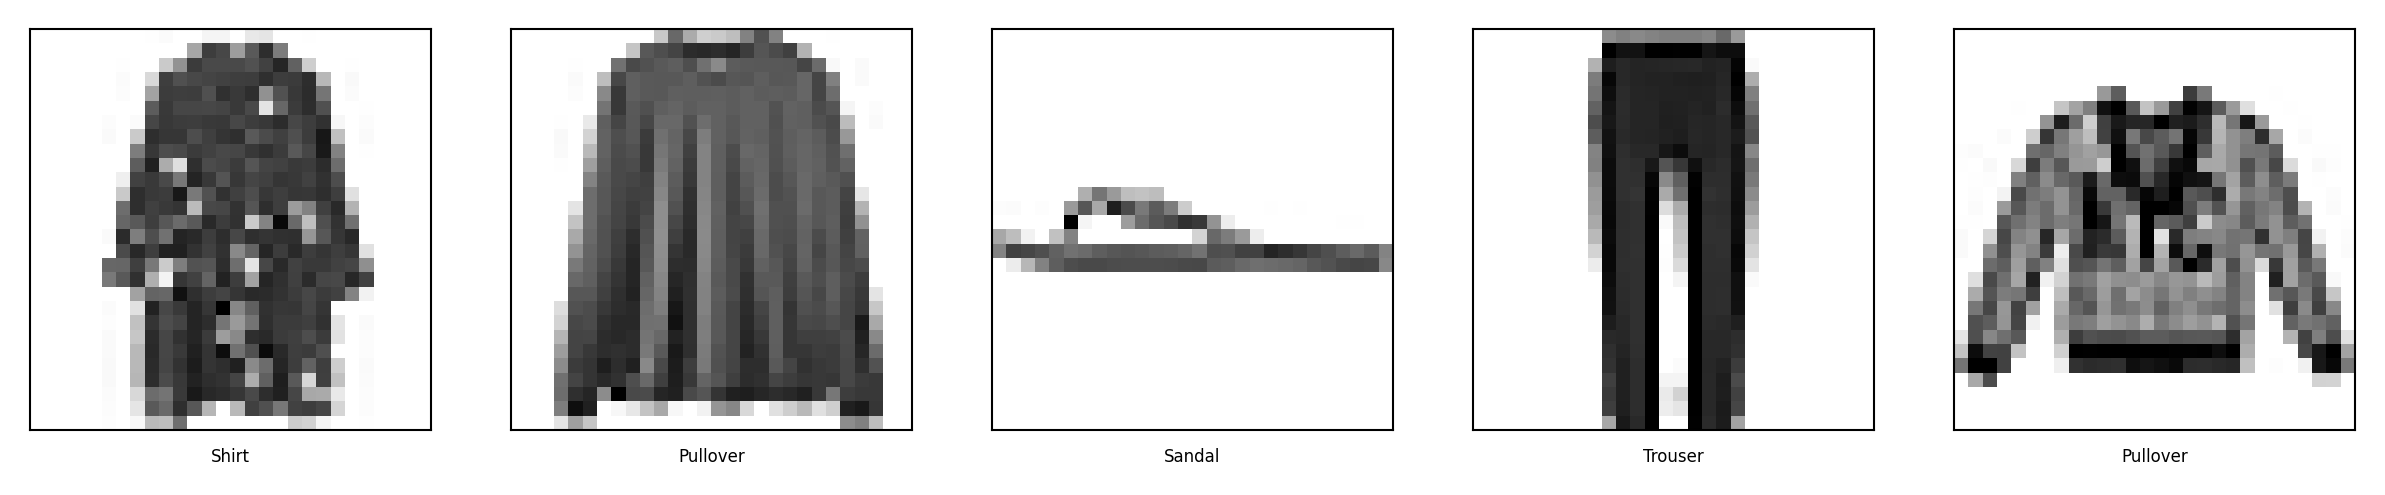

In [39]:
# Download FMINST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(40996)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(fmnist_classes[y[n]]))
plt.show();

### Building the network
* We first build a simple sequential model (no branches)
* Input layer ('input_shape'): a flat vector of 28*28=784 nodes
    * We'll see how to properly deal with images later
* Two dense hidden layers: 512 nodes each, ReLU activation
    * Glorot weight initialization is applied by default
* Output layer: 10 nodes (for 10 classes) and softmax activation

``` python
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
```

In [40]:
from tensorflow.keras import initializers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))

#### Model summary
- Lots of parameters (weights and biases) to learn!
    - hidden layer 1 : (28 * 28 + 1) * 512 = 401920
    - hidden layer 2 : (512 + 1) * 512 = 262656
    - output layer: (512 + 1) * 10 = 5130
    
``` python
network.summary()
```

In [41]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Choosing loss, optimizer, metrics
* __Loss function__
    - Cross-entropy (log loss) for multi-class classification ($y_{true}$ is one-hot encoded)
    - Use binary crossentropy for binary problems (single output node) 
    - Use sparse categorical crossentropy if $y_{true}$ is label-encoded (1,2,3,...)
* __Optimizer__
    - Any of the optimizers we discussed before. RMSprop usually works well.
* __Metrics__ 
    - To monitor performance during training and testing, e.g. accuracy
    
``` python
# Shorthand
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# Detailed
network.compile(loss=CategoricalCrossentropy(label_smoothing=0.01),
                optimizer=RMSprop(learning_rate=0.001, momentum=0.0)
                metrics=[Accuracy()])
```

In [42]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Preprocessing: Normalization, Reshaping, Encoding 
* Always normalize (standardize or min-max) the inputs. Mean should be close to 0.
    - Avoid that some inputs overpower others
    - Speed up convergence 
        - Gradients of activation functions $\frac{\partial a_{h}}{\partial z_{h}}$ are (near) 0 for large inputs
        - If some gradients become much larger than others, SGD will start zig-zagging
* Reshape the data to fit the shape of the input layer, e.g. (n, 28*28) or (n, 28,28)
    - Tensor with instances in first dimension, rest must match the input layer 
* In multi-class classification, every class is an output node, so one-hot-encode the labels
    - e.g. class '4' becomes [0,0,0,0,1,0,0,0,0,0]
    
```python
X = X.astype('float32') / 255
X = X.reshape((60000, 28 * 28))
y = to_categorical(y)
```

In [43]:
from sklearn.model_selection import train_test_split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X, y, train_size=60000, shuffle=True, random_state=0)

Xf_train = Xf_train.reshape((60000, 28 * 28))
Xf_test = Xf_test.reshape((10000, 28 * 28))

# TODO: check if standardization works better
Xf_train = Xf_train.astype('float32') / 255
Xf_test = Xf_test.astype('float32') / 255

from tensorflow.keras.utils import to_categorical
yf_train = to_categorical(yf_train)
yf_test = to_categorical(yf_test)

### Choosing training hyperparameters
* Number of epochs: enough to allow convergence
    * Too much: model starts overfitting (or just wastes time)
* Batch size: small batches (e.g. 32, 64,... samples) often preferred
    * 'Noisy' training data makes overfitting less likely
        * Larger batches generalize less well ('generalization gap')
    * Requires less memory (especially in GPUs)
    * Large batches do speed up training, may converge in fewer epochs
* [Batch size interacts with learning rate](https://openreview.net/pdf?id=B1Yy1BxCZ)
    * Instead of shrinking the learning rate you can increase batch size
    
``` python
history = network.fit(X_train, y_train, epochs=3, batch_size=32);
```

In [44]:
history = network.fit(Xf_train, yf_train, epochs=3, batch_size=32, verbose=0);

2023-09-22 09:09:27.549837: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-22 09:09:27.889092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Predictions and evaluations
We can now call `predict` to generate predictions, and evaluate the trained model on the entire test set

``` python
network.predict(X_test)
test_loss, test_acc = network.evaluate(X_test, y_test)
```

2023-09-22 09:18:52.963181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[0.0090286 0.0000066 0.8731063 0.0004194 0.0108315 0.0000054 0.1064771
 0.0000001 0.0001248 0.0000002]


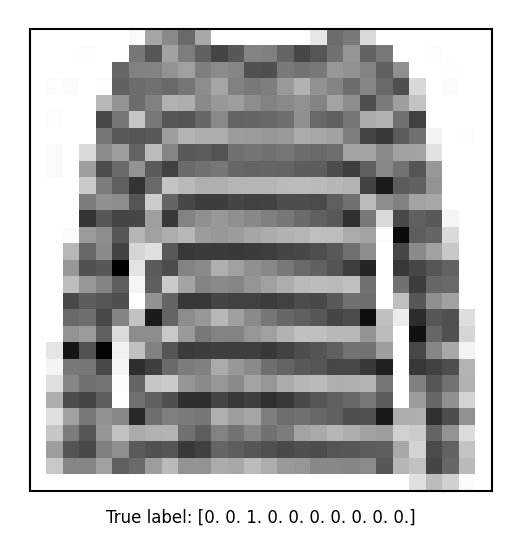

In [57]:
np.set_printoptions(precision=7)
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
sample_id = 4
axes.imshow(Xf_test[sample_id].reshape(28, 28), cmap=plt.cm.gray_r)
axes.set_xlabel("True label: {}".format(yf_test[sample_id]))
axes.set_xticks([])
axes.set_yticks([])
print(network.predict(Xf_test, verbose=0)[sample_id])

In [56]:
test_loss, test_acc = network.evaluate(Xf_test, yf_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.8842999935150146


## Model selection
* How many epochs do we need for training?
* Train the neural net and track the loss after every iteration on a validation set
    * You can add a callback to the fit version to get info on every epoch
* Best model after a few epochs, then starts overfitting

In [47]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8,3))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #", fontsize=18*fig_scale)
            plt.ylabel("Loss/Accuracy", fontsize=18*fig_scale)
            plt.legend(prop={'size': 15*fig_scale})
            plt.tick_params(axis='both', labelsize=16*fig_scale)
            plt.show()

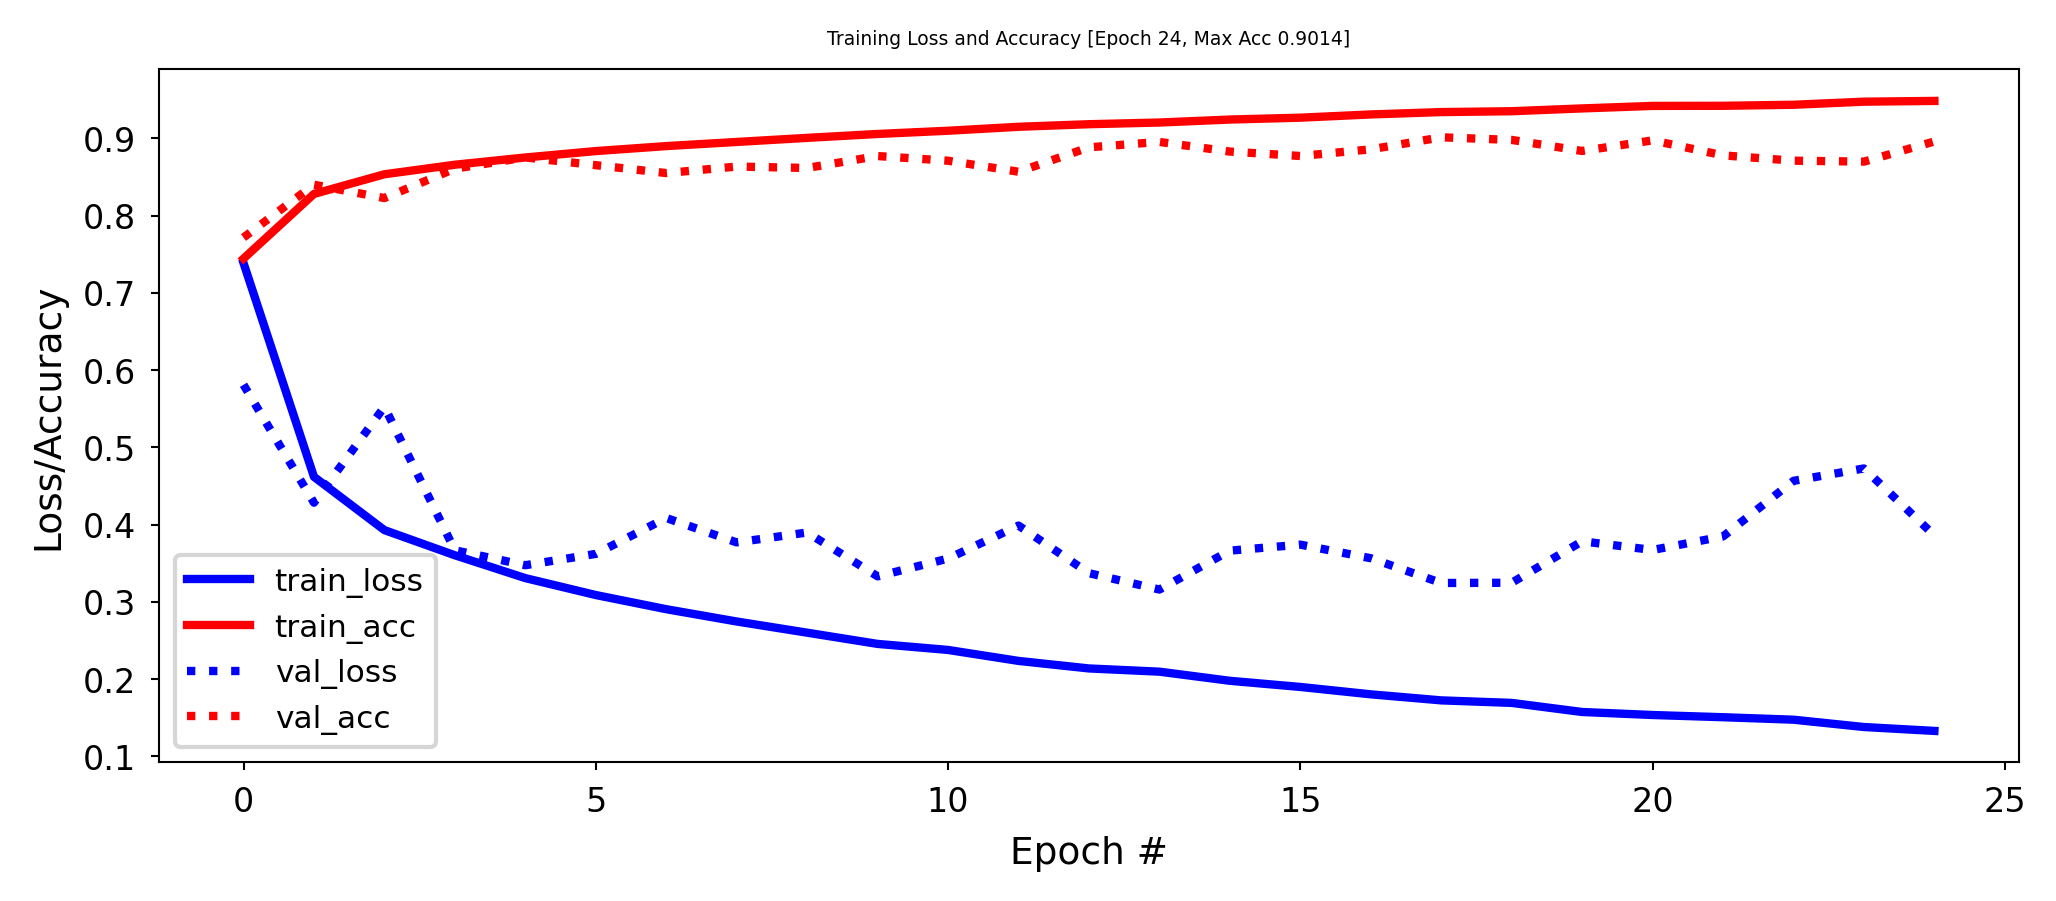

In [48]:
from sklearn.model_selection import train_test_split

x_val, partial_x_train = Xf_train[:10000], Xf_train[10000:]
y_val, partial_y_train = yf_train[:10000], yf_train[10000:] 
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=25, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

### Early stopping
* Stop training when the validation loss (or validation accuracy) no longer improves
* Loss can be bumpy: use a moving average or wait for $k$ steps without improvement

``` python
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs=25, batch_size=512, callbacks=[earlystop])
```

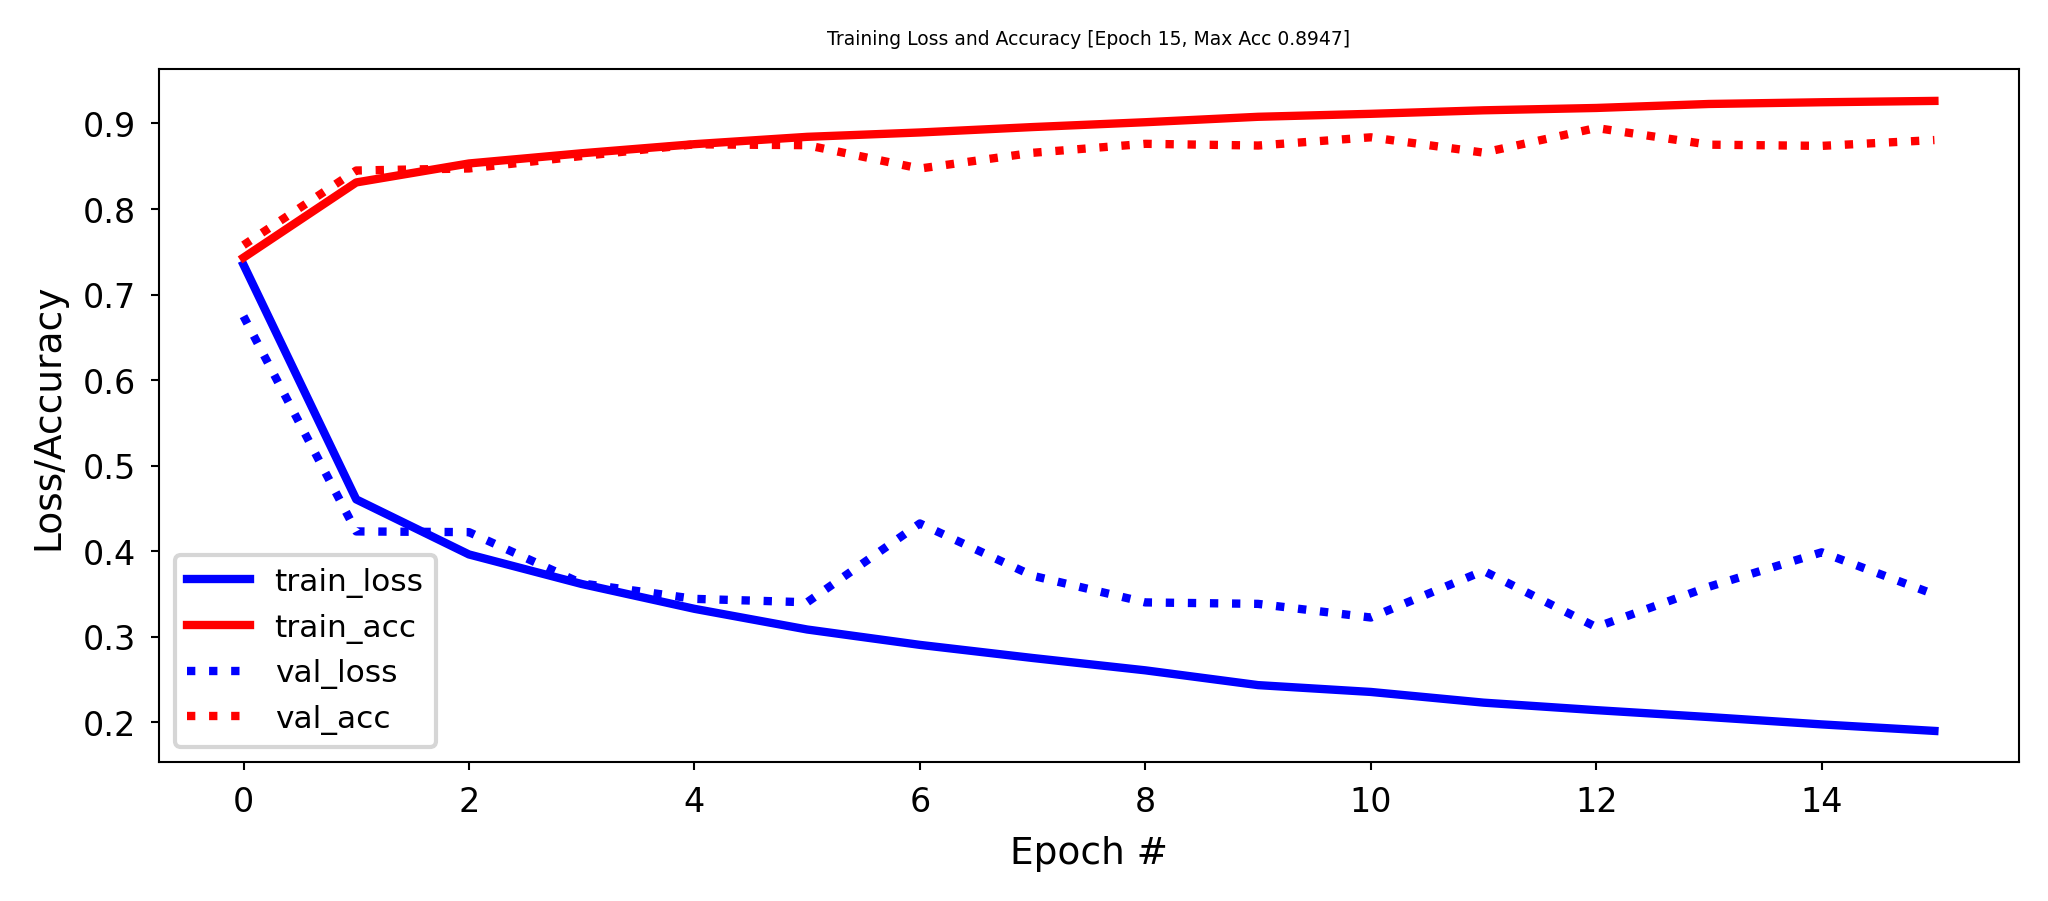

In [49]:
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=25, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

### Regularization and memorization capacity
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - Too high capacity causes overfitting, too low causes underfitting
    - In the extreme, the training set can be 'memorized' in the weights
* Smaller models are forced it to learn a compressed representation that generalizes better
    - Find the sweet spot: e.g. start with few parameters, increase until overfitting stars.
* Example: 256 nodes in first layer, 32 nodes in second layer, similar performance

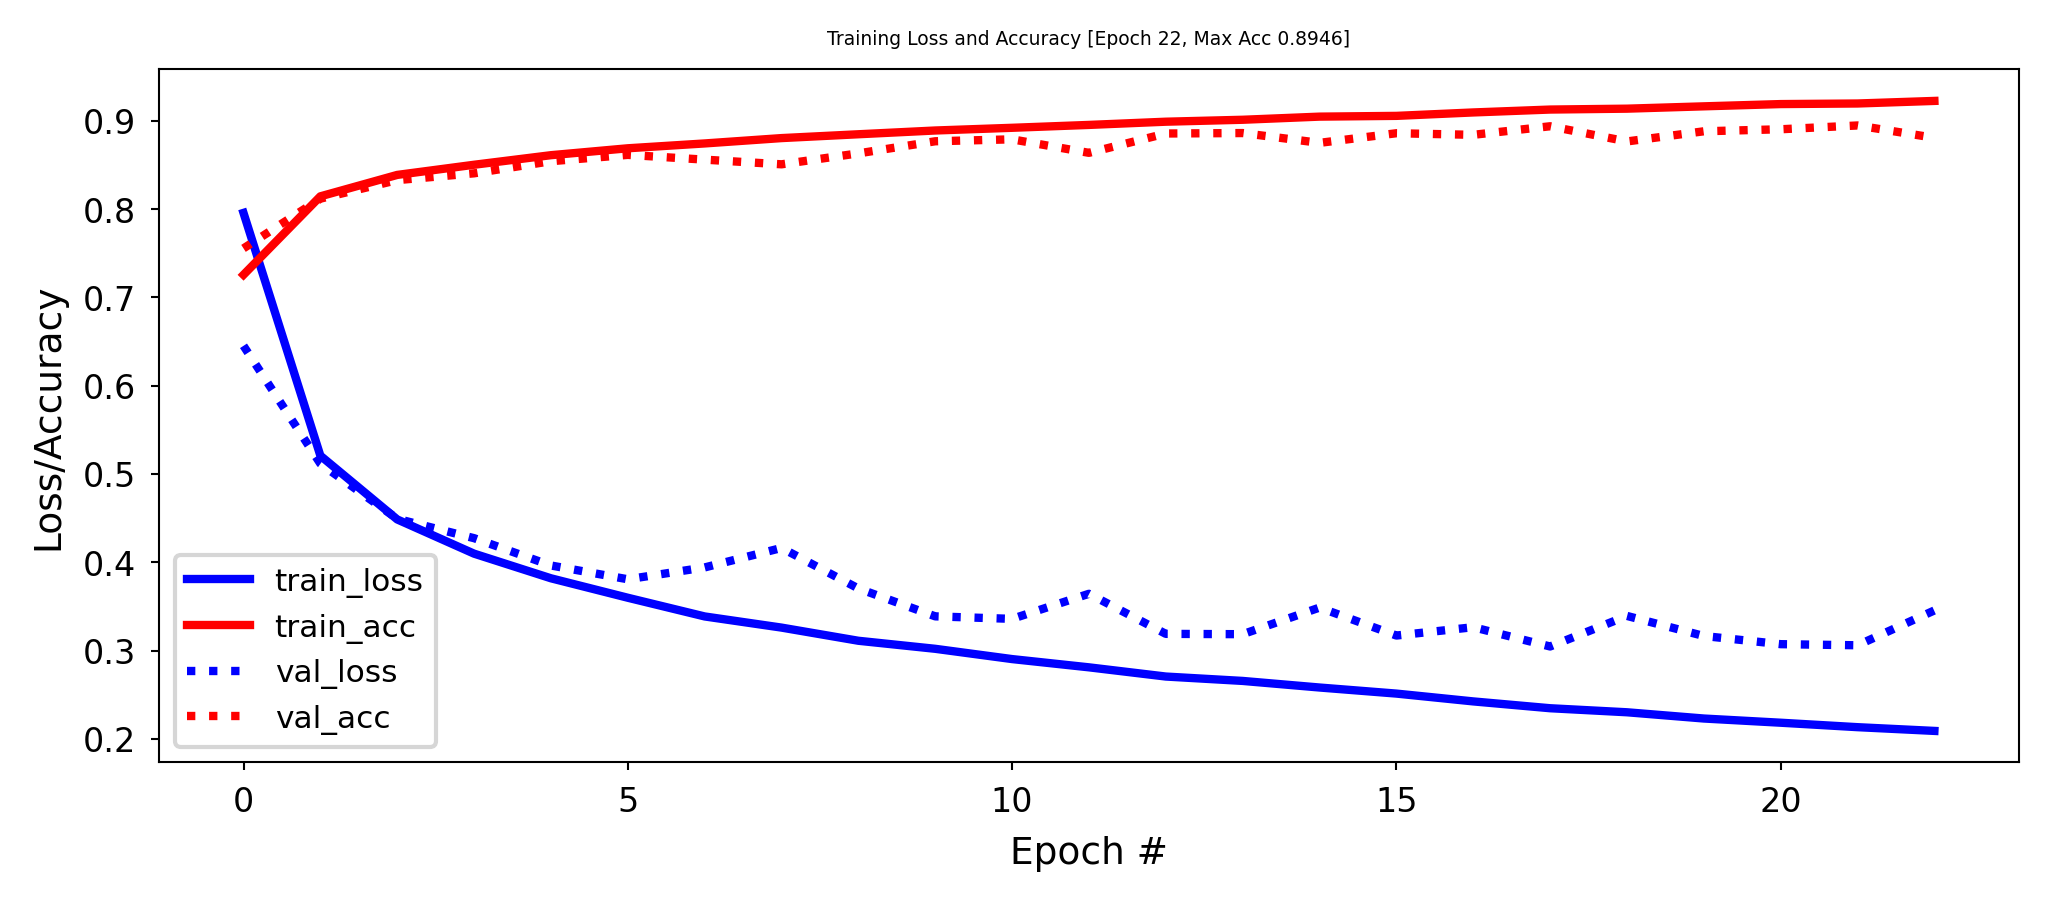

In [50]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=30, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

#### Information bottleneck
* If a layer is too narrow, it will lose information that can never be recovered by subsequent layers
* _Information bottleneck_ theory defines a bound on the capacity of the network
* Imagine that you need to learn 10 outputs (e.g. classes) and your hidden layer has 2 nodes
    * This is like trying to learn 10 hyperplanes from a 2-dimensional representation
* Example: bottleneck of 2 nodes, no overfitting, much higher training loss 

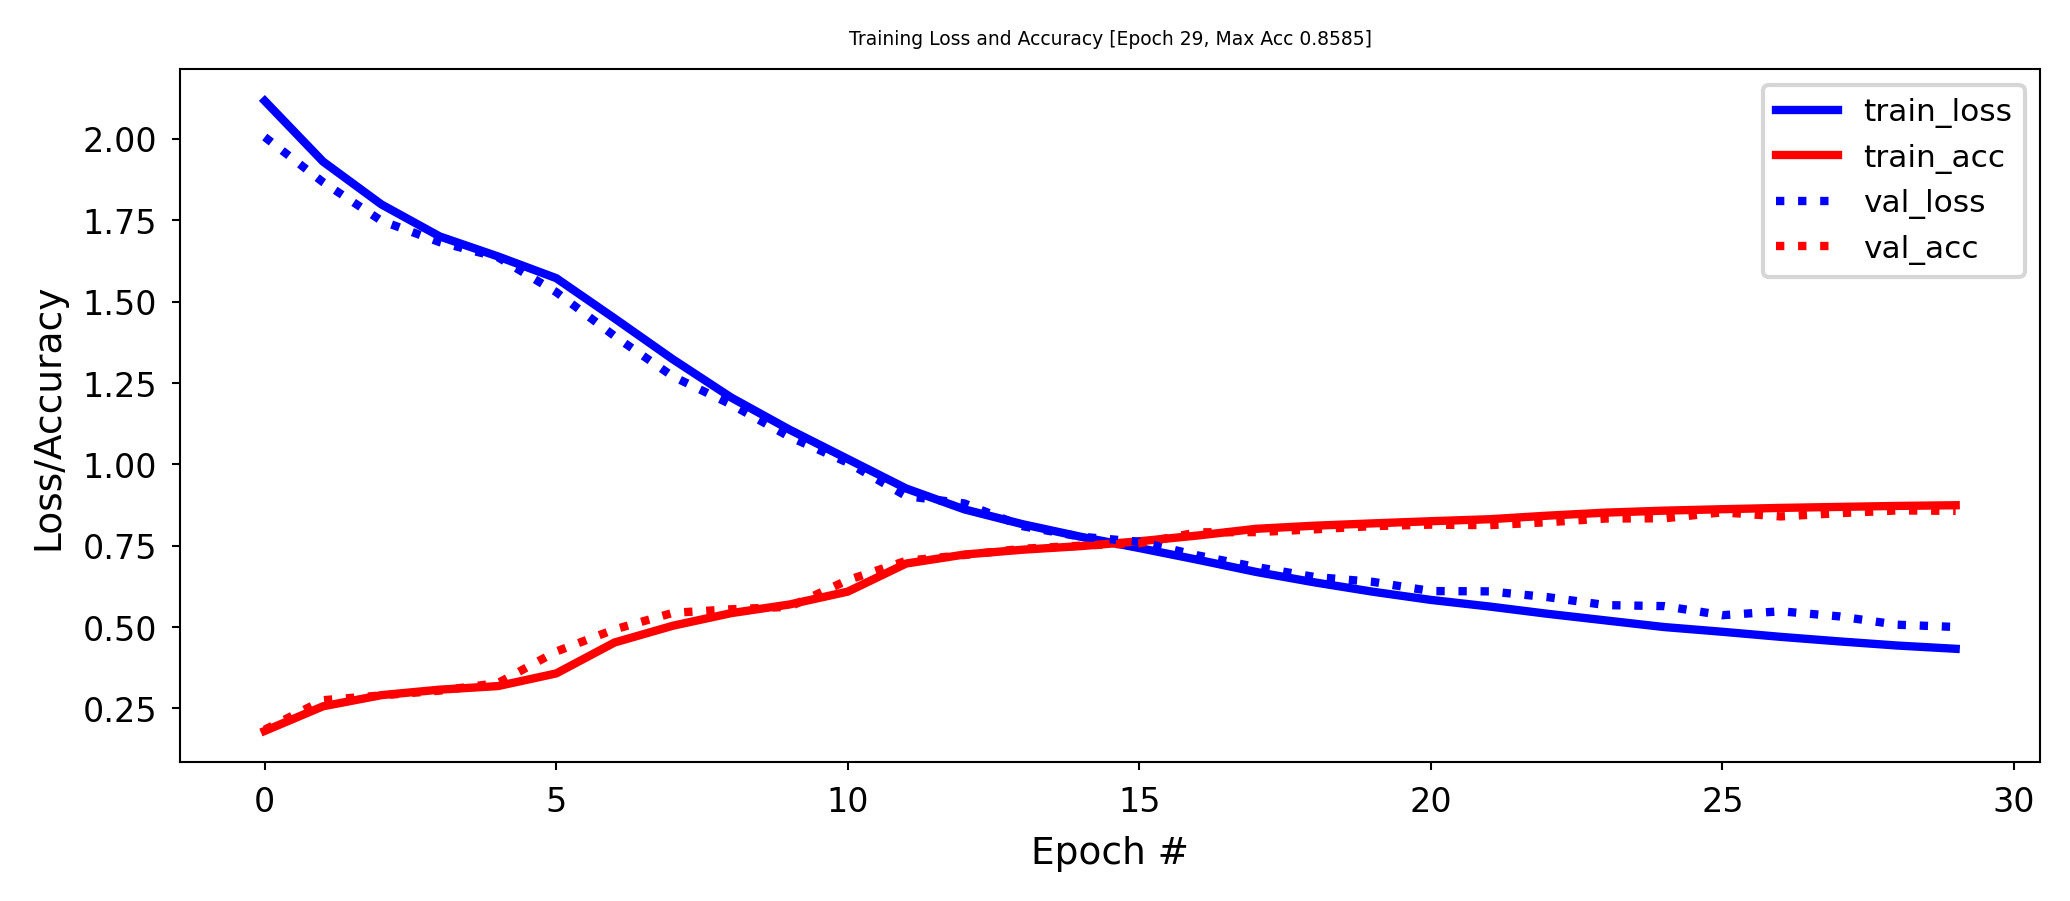

In [51]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(2, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=30, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

#### Weight regularization (weight decay)
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights

``` python
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(28 * 28,)))
network.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
```

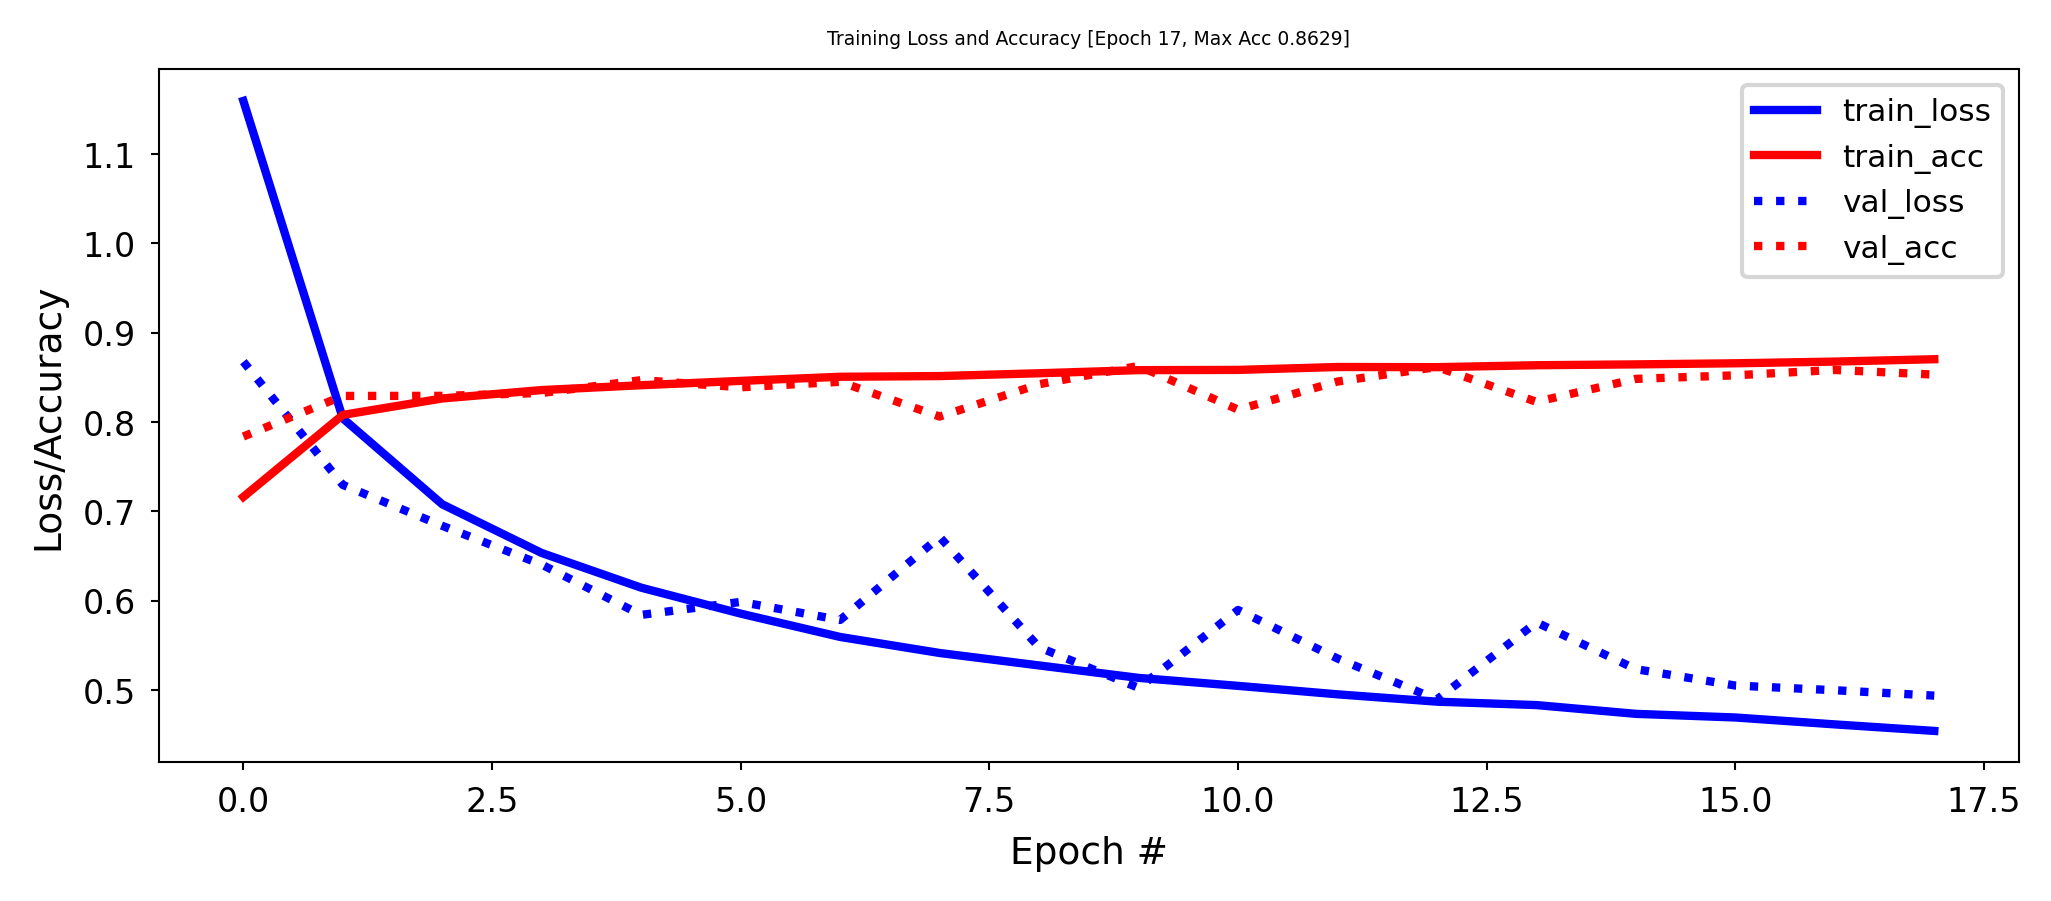

In [52]:
from tensorflow.keras import regularizers

network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(28 * 28,)))
network.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

### Dropout
* Every iteration, randomly set a number of activations $a_i$ to 0
* _Dropout rate_ : fraction of the outputs that are zeroed-out (e.g. 0.1 - 0.5)
* Idea: break up accidental non-significant learned patterns 
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training

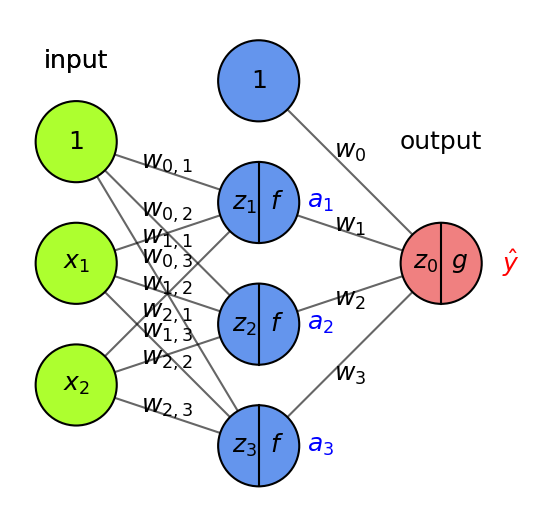

In [53]:
fig = plt.figure(figsize=(4*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1], draw_bias=True, labels=True, 
                show_activations=True, activation=True)

#### Dropout layers
* Dropout is usually implemented as a special layer

``` python
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))
```

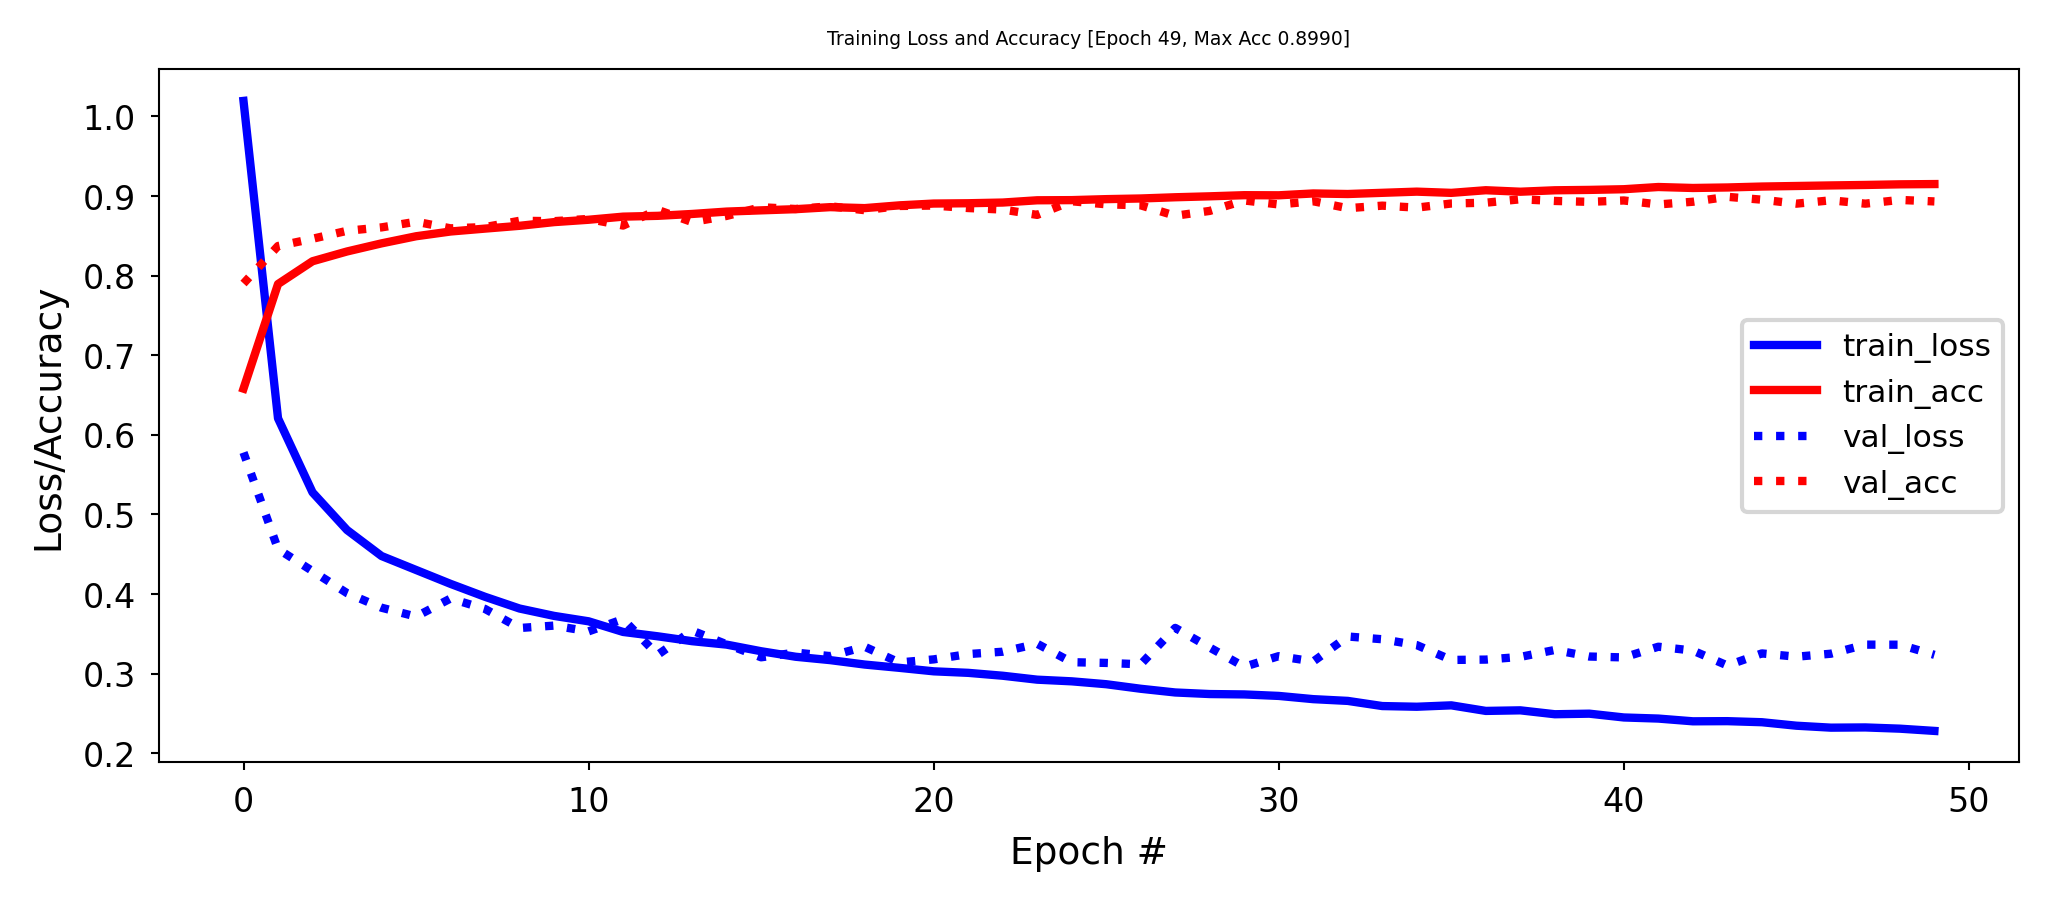

In [54]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Batch Normalization
* We've seen that scaling the input is important, but what if layer activations become very large? 
    * Same problems, starting deeper in the network
* Batch normalization: normalize the activations of the previous layer within each batch
    * Within a batch, set the mean activation close to 0 and the standard deviation close to 1
        * Across badges, use exponential moving average of batch-wise mean and variance
    * Allows deeper networks less prone to vanishing or exploding gradients

``` python
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
```

```python

```


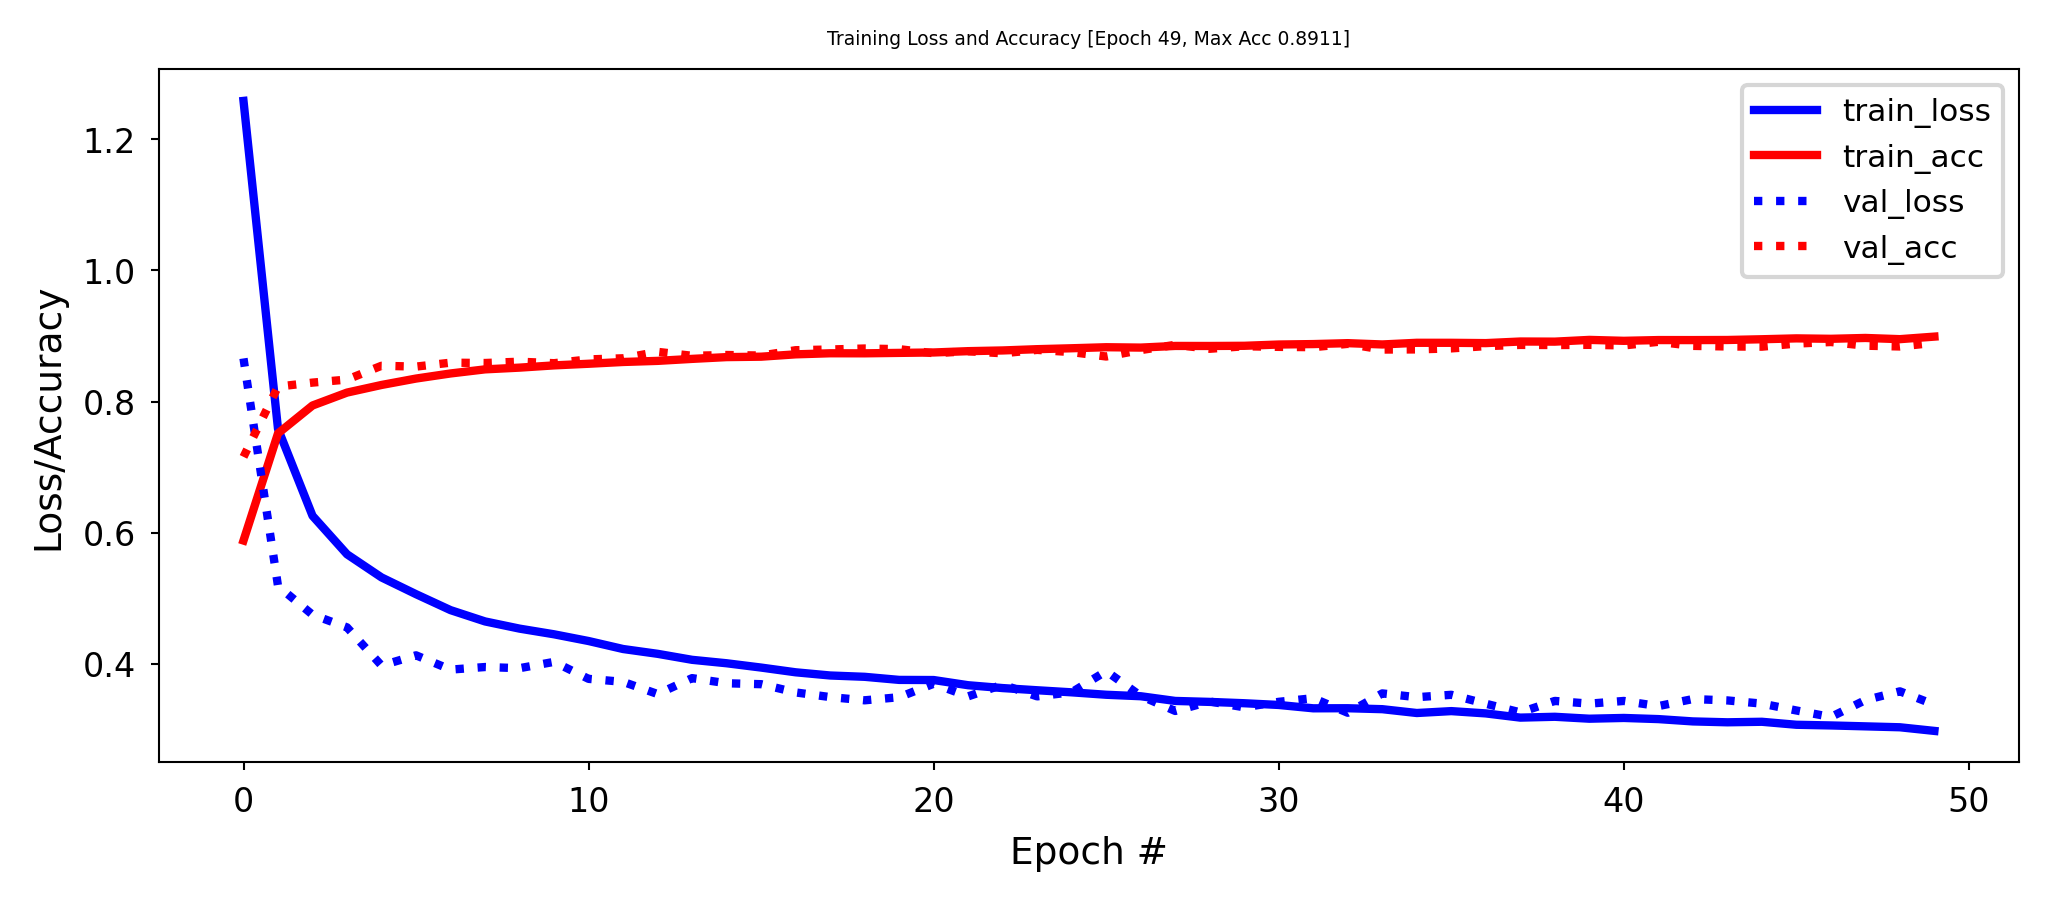

In [55]:
network = models.Sequential()
network.add(layers.Dense(265, activation='relu', input_shape=(28 * 28,)))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

### Tuning multiple hyperparameters
* You can wrap Keras models as scikit-learn models and use any tuning technique
* Keras also has built-in RandomSearch (and HyperBand and BayesianOptimization - see later)

```python
def make_model(hp):
    m.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    m.compile(optimizer=Adam(hp.Choice('learning rate', [1e-2, 1e-3, 1e-4])))
    return model
```

```python
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
clf = KerasClassifier(make_model)
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)

from kerastuner.tuners import RandomSearch
tuner = keras.RandomSearch(build_model, max_trials=5)
```

## Summary

* Neural architectures
* Training neural nets
    * Forward pass: Tensor operations
    * Backward pass: Backpropagation
* Neural network design:
    * Activation functions
    * Weight initialization
    * Optimizers
* Neural networks in practice
* Model selection
    * Early stopping
    * Memorization capacity and information bottleneck
    * L1/L2 regularization
    * Dropout
    * Batch normalization